## Import libraries

In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool, to_hetero
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, rdchem
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


## Load and explore data

In [2]:
# Cell 2: Load the data files
drugs_df = pd.read_csv('drugs.csv')
proteins_df = pd.read_csv('proteins.csv')
affinity_df = pd.read_csv('drug_protein_affinity.csv')

print("Data loaded successfully!")
print(f"Drugs: {len(drugs_df)}")
print(f"Proteins: {len(proteins_df)}")
print(f"Drug-Protein interactions: {len(affinity_df)}")
print(f"Affinity range: {affinity_df['Affinity'].min():.2f} - {affinity_df['Affinity'].max():.2f}")

# Create binary labels (1 for strong interaction, 0 for weak)
# You can adjust this threshold based on your domain knowledge
affinity_threshold = 7.0  
affinity_df['label'] = (affinity_df['Affinity'] >= affinity_threshold).astype(int)

print(f"Positive interactions (>= {affinity_threshold}): {affinity_df['label'].sum()}")
print(f"Negative interactions (< {affinity_threshold}): {len(affinity_df) - affinity_df['label'].sum()}")

Data loaded successfully!
Drugs: 68
Proteins: 433
Drug-Protein interactions: 29444
Affinity range: 5.00 - 10.80
Positive interactions (>= 7.0): 2383
Negative interactions (< 7.0): 27061


## Drug moleculare graph creation

In [3]:
# Cell 3: Convert SMILES to molecular graphs
def smiles_to_graph(smiles):
    """Convert SMILES string to molecular graph"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ]
        atom_features.append(features)
    
    # Get bond information (edges)
    edge_indices = []
    edge_attrs = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.extend([[i, j], [j, i]])  # Add both directions
        
        bond_type = bond.GetBondType()
        bond_features = [int(bond_type), int(bond.GetIsAromatic())]
        edge_attrs.extend([bond_features, bond_features])
    
    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Process all drug molecules
drug_graphs = {}
for idx, row in drugs_df.iterrows():
    smiles = row['Canonical_SMILES']
    graph = smiles_to_graph(smiles)
    if graph is not None:
        drug_graphs[row['Drug_Index']] = graph

print(f"Successfully processed {len(drug_graphs)} drug molecules")

Successfully processed 68 drug molecules


## Protein feature generation

In [6]:
# Cell 4: Generate protein features from sequences
import numpy as np
import torch

def protein_to_features(sequence, max_length=1000):
    """Convert protein sequence to numerical features"""
    # Amino acid encoding
    aa_dict = {
        'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8,
        'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
        'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20, 'X': 0
    }
    
    # Truncate or pad sequence
    sequence = sequence[:max_length]
    
    # Convert to numbers
    encoded = [aa_dict.get(aa, 0) for aa in sequence]
    
    # Pad if necessary
    if len(encoded) < max_length:
        encoded.extend([0] * (max_length - len(encoded)))
    
    return np.array(encoded)

# Process protein sequences
protein_features = {}
for idx, row in proteins_df.iterrows():
    sequence = row['Sequence']
    features = protein_to_features(sequence)
    protein_features[row['Protein_Index']] = torch.tensor(features, dtype=torch.float)

# Stack all protein features into a single tensor for GNN input
all_features = torch.stack(list(protein_features.values()))

print(f"Processed {len(protein_features)} protein sequences")
print(f"All protein features shape: {all_features.shape}")

Processed 433 protein sequences
All protein features shape: torch.Size([433, 1000])


## Create a bipartite graph dataset

In [7]:
# Cell 5: Create heterogeneous graph dataset
def create_hetero_graph(drug_graphs, protein_features, interactions_df):
    """Create heterogeneous graph with drugs and proteins"""
    
    # Prepare drug node features (using molecular descriptors as backup)
    drug_features = []
    drug_indices = []
    
    for drug_idx in sorted(drug_graphs.keys()):
        if drug_idx in drug_graphs:
            # Use average of atom features as drug representation
            graph = drug_graphs[drug_idx]
            drug_feat = torch.mean(graph.x, dim=0)
            # Pad/truncate to fixed size
            if len(drug_feat) < 20:
                drug_feat = F.pad(drug_feat, (0, 20 - len(drug_feat)))
            else:
                drug_feat = drug_feat[:20]
            drug_features.append(drug_feat)
            drug_indices.append(drug_idx)
    
    # Prepare protein node features
    protein_feat_list = []
    protein_indices = []
    
    for protein_idx in sorted(protein_features.keys()):
        # Use first 100 features to keep it manageable
        feat = protein_features[protein_idx][:100]
        protein_feat_list.append(feat)
        protein_indices.append(protein_idx)
    
    # Create mappings
    drug_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(drug_indices)}
    protein_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(protein_indices)}
    
    # Create edge indices for interactions
    edge_indices = []
    edge_labels = []
    
    for _, row in interactions_df.iterrows():
        if row['Drug_Index'] in drug_idx_map and row['Protein_Index'] in protein_idx_map:
            drug_new_idx = drug_idx_map[row['Drug_Index']]
            protein_new_idx = protein_idx_map[row['Protein_Index']]
            
            edge_indices.append([drug_new_idx, protein_new_idx])
            edge_labels.append(row['label'])
    
    # Convert to tensors
    drug_x = torch.stack(drug_features)
    protein_x = torch.stack(protein_feat_list)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t()
    edge_labels = torch.tensor(edge_labels, dtype=torch.float)
    
    return {
        'drug_x': drug_x,
        'protein_x': protein_x, 
        'edge_index': edge_index,
        'edge_labels': edge_labels,
        'drug_idx_map': drug_idx_map,
        'protein_idx_map': protein_idx_map
    }

# Create the dataset
graph_data = create_hetero_graph(drug_graphs, protein_features, affinity_df)

print("Heterogeneous graph created!")
print(f"Drug nodes: {graph_data['drug_x'].shape}")
print(f"Protein nodes: {graph_data['protein_x'].shape}")
print(f"Edges: {graph_data['edge_index'].shape}")
print(f"Labels: {graph_data['edge_labels'].shape}")

Heterogeneous graph created!
Drug nodes: torch.Size([68, 20])
Protein nodes: torch.Size([433, 100])
Edges: torch.Size([2, 29444])
Labels: torch.Size([29444])


## Define the GCN model architecture

In [9]:
# Cell 6: Define the DTI-GCN model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class DTI_GCN(nn.Module):
    def __init__(self, drug_input_dim, protein_input_dim, hidden_dim=128, output_dim=64):
        super(DTI_GCN, self).__init__()
        
        # Drug processing layers
        self.drug_embedding = nn.Linear(drug_input_dim, hidden_dim)
        self.drug_gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.drug_gcn2 = GCNConv(hidden_dim, output_dim)
        
        # Protein processing layers  
        self.protein_embedding = nn.Linear(protein_input_dim, hidden_dim)
        self.protein_conv1 = nn.Conv1d(1, 32, kernel_size=8, stride=1, padding=4)
        self.protein_conv2 = nn.Conv1d(32, 64, kernel_size=8, stride=1, padding=4)
        self.protein_pool = nn.AdaptiveAvgPool1d(output_dim)
        
        # Interaction prediction layers
        self.interaction_mlp = nn.Sequential(
            nn.Linear(output_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(), 
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, drug_x, protein_x, drug_indices, protein_indices):
        # Process drugs with GCN
        drug_h = F.relu(self.drug_embedding(drug_x))
        
        # Create drug graph edges (fully connected for simplicity)
        num_drugs = drug_x.size(0)
        drug_edge_index = torch.combinations(torch.arange(num_drugs), r=2).t()
        drug_edge_index = torch.cat([drug_edge_index, drug_edge_index.flip(0)], dim=1)
        
        drug_h = F.relu(self.drug_gcn1(drug_h, drug_edge_index))
        drug_h = self.dropout(drug_h)
        drug_h = self.drug_gcn2(drug_h, drug_edge_index)
        
        # Process proteins with CNN
        protein_h = protein_x.unsqueeze(1)  # Add channel dimension
        protein_h = F.relu(self.protein_conv1(protein_h))
        protein_h = F.relu(self.protein_conv2(protein_h))
        protein_h = self.protein_pool(protein_h).squeeze(-1)  # Global pooling
        
        # Get drug-protein pairs for prediction
        drug_features = drug_h[drug_indices]
        protein_features = protein_h[protein_indices]
        
        # Concatenate features and predict interaction
        combined_features = torch.cat([drug_features, protein_features], dim=1)
        interaction_scores = self.interaction_mlp(combined_features)
        
        return torch.sigmoid(interaction_scores.squeeze())

# Initialize model with correct input dimensions
drug_input_dim = graph_data['drug_x'].shape[1]      # number of drug features
protein_input_dim = graph_data['protein_x'].shape[1]  # number of protein features

model = DTI_GCN(drug_input_dim, protein_input_dim)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(model)

Model initialized with 81953 parameters
DTI_GCN(
  (drug_embedding): Linear(in_features=20, out_features=128, bias=True)
  (drug_gcn1): GCNConv(128, 128)
  (drug_gcn2): GCNConv(128, 64)
  (protein_embedding): Linear(in_features=100, out_features=128, bias=True)
  (protein_conv1): Conv1d(1, 32, kernel_size=(8,), stride=(1,), padding=(4,))
  (protein_conv2): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=(4,))
  (protein_pool): AdaptiveAvgPool1d(output_size=64)
  (interaction_mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)


## training setup

In [11]:
# Cell 7: Prepare training
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

# Move data to device
drug_x = graph_data['drug_x'].to(device)
protein_x = graph_data['protein_x'].to(device)
edge_index = graph_data['edge_index'].to(device)
edge_labels = graph_data['edge_labels'].to(device)

# Split data into train/validation/test
num_edges = edge_index.shape[1]  # number of edges
indices = np.arange(num_edges)

train_indices, temp_indices = train_test_split(
    indices, test_size=0.4, random_state=42, 
    stratify=edge_labels.cpu().numpy()
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=42,
    stratify=edge_labels[temp_indices].cpu().numpy()
)

print(f"Training edges: {len(train_indices)}")
print(f"Validation edges: {len(val_indices)}")
print(f"Test edges: {len(test_indices)}")

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

Using device: cpu
Training edges: 17666
Validation edges: 5889
Test edges: 5889


## Training loop

In [16]:
# Cell 8: Training function and loop
from sklearn.metrics import accuracy_score, roc_auc_score

def train_epoch(model, optimizer, criterion, train_indices):
    model.train()
    optimizer.zero_grad()
    
    # Get drug-protein indices for training edges
    drug_indices = edge_index[0, train_indices]
    protein_indices = edge_index[1, train_indices]
    
    # Forward pass
    predictions = model(drug_x, protein_x, drug_indices, protein_indices)
    labels = edge_labels[train_indices]
    
    # Calculate loss
    loss = criterion(predictions, labels)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()

def evaluate(model, indices):
    model.eval()
    with torch.no_grad():
        # Get drug-protein indices for evaluation edges
        drug_indices = edge_index[0, indices]
        protein_indices = edge_index[1, indices]
        
        predictions = model(drug_x, protein_x, drug_indices, protein_indices)
        labels = edge_labels[indices]
        
        # Calculate metrics
        pred_binary = (predictions > 0.5).float()
        accuracy = accuracy_score(labels.cpu(), pred_binary.cpu())
        auc = roc_auc_score(labels.cpu(), predictions.cpu())
        
        return accuracy, auc

# Training loop
num_epochs = 200
train_losses = []
val_accuracies = []
val_aucs = []

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, optimizer, criterion, train_indices)
    train_losses.append(train_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        val_acc, val_auc = evaluate(model, val_indices)
        val_accuracies.append(val_acc)
        val_aucs.append(val_auc)
        
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")
        
        # Learning rate scheduling
        scheduler.step(train_loss)

print("Training completed!")

Starting training...
Epoch   0 | Train Loss: 0.7072 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  10 | Train Loss: 0.7090 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  20 | Train Loss: 0.7080 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  30 | Train Loss: 0.7101 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  40 | Train Loss: 0.7079 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  50 | Train Loss: 0.7103 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  60 | Train Loss: 0.7097 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  70 | Train Loss: 0.7068 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  80 | Train Loss: 0.7088 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch  90 | Train Loss: 0.7113 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch 100 | Train Loss: 0.7104 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch 110 | Train Loss: 0.7100 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch 120 | Train Loss: 0.7097 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch 130 | Train Loss: 0.7092 | Val Acc: 0.0810 | Val AUC: 0.5335
Epoch 140 | Train Loss: 0.7079 | Val Acc:

## model eval

Final Evaluation:
--------------------------------------------------
Training   - Accuracy: 0.0809, AUC: 0.5241
Validation - Accuracy: 0.0810, AUC: 0.5335
Test       - Accuracy: 0.0808, AUC: 0.5226


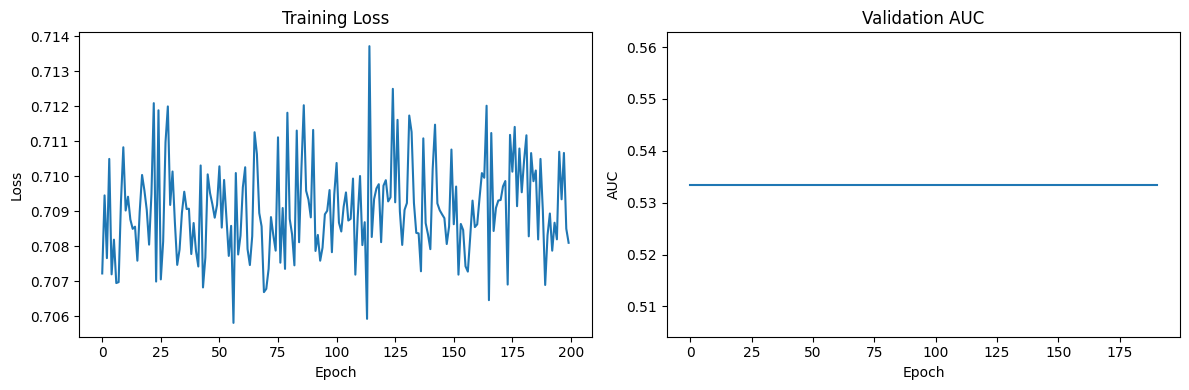

In [17]:
# Cell 9: Final evaluation
print("Final Evaluation:")
print("-" * 50)

# Training set evaluation
train_acc, train_auc = evaluate(model, train_indices)
print(f"Training   - Accuracy: {train_acc:.4f}, AUC: {train_auc:.4f}")

# Validation set evaluation  
val_acc, val_auc = evaluate(model, val_indices)
print(f"Validation - Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

# Test set evaluation
test_acc, test_auc = evaluate(model, test_indices)
print(f"Test       - Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
epochs_eval = range(0, num_epochs, 10)
plt.plot(epochs_eval, val_aucs)
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.tight_layout()
plt.show()

## prediction function

In [19]:
# Cell 10: Create prediction function for new drug-protein pairs
def predict_interaction(model, drug_idx, protein_idx):
    """Predict interaction between a specific drug and protein"""
    model.eval()
    
    # Check if indices exist in our mappings
    if drug_idx not in graph_data['drug_idx_map'] or protein_idx not in graph_data['protein_idx_map']:
        return None, "Drug or protein not found in dataset"
    
    # Get mapped indices
    mapped_drug_idx = graph_data['drug_idx_map'][drug_idx]
    mapped_protein_idx = graph_data['protein_idx_map'][protein_idx]
    
    # Create edge for prediction
    test_edge = torch.tensor([[mapped_drug_idx], [mapped_protein_idx]], dtype=torch.long).to(device)
    
    with torch.no_grad():
        # Split edge into drug_indices and protein_indices
        drug_indices = test_edge[0]
        protein_indices = test_edge[1]

        prediction = model(drug_x, protein_x, drug_indices, protein_indices)
        probability = prediction.item()
        predicted_label = 1 if probability > 0.5 else 0
    
    return probability, predicted_label

# Example predictions
print("Example Predictions:")
print("-" * 40)

# Test a few drug-protein pairs
test_pairs = [(0, 0), (1, 10), (5, 20)]

for drug_idx, protein_idx in test_pairs:
    prob, label = predict_interaction(model, drug_idx, protein_idx)
    if prob is not None:
        print(f"Drug {drug_idx} - Protein {protein_idx}: Probability = {prob:.4f}, Prediction = {label}")
    else:
        print(f"Drug {drug_idx} - Protein {protein_idx}: {label}")

Example Predictions:
----------------------------------------
Drug 0 - Protein 0: Probability = 0.5115, Prediction = 1
Drug 1 - Protein 10: Probability = 0.5123, Prediction = 1
Drug 5 - Protein 20: Probability = 0.5109, Prediction = 1


## Model saving and summary

In [20]:
# Cell 11: Save model and create summary
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'drug_idx_map': graph_data['drug_idx_map'],
    'protein_idx_map': graph_data['protein_idx_map'],
    'model_config': {
        'drug_input_dim': drug_input_dim,
        'protein_input_dim': protein_input_dim,
        'hidden_dim': 128,
        'output_dim': 64
    }
}, 'dti_gcn_model.pth')

print("Model saved successfully!")

# Create summary
print("\n" + "="*60)
print("DTI-GCN MODEL SUMMARY")
print("="*60)
print(f"Dataset Size:")
print(f"  - Drugs: {len(drug_graphs)}")
print(f"  - Proteins: {len(protein_features)}")
print(f"  - Interactions: {len(affinity_df)}")
print(f"  - Positive samples: {affinity_df['label'].sum()}")
print(f"  - Negative samples: {len(affinity_df) - affinity_df['label'].sum()}")

print(f"\nModel Architecture:")
print(f"  - Drug input dimension: {drug_input_dim}")
print(f"  - Protein input dimension: {protein_input_dim}")
print(f"  - Hidden dimension: 128")
print(f"  - Output dimension: 64")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nPerformance:")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"  - Test AUC: {test_auc:.4f}")

print(f"\nNext Steps:")
print("  1. Experiment with different GNN architectures (GAT, GraphSAGE)")
print("  2. Add more sophisticated protein representations")
print("  3. Include molecular descriptors as additional features")
print("  4. Implement attention mechanisms")
print("  5. Add ensemble methods")
print("="*60)

Model saved successfully!

DTI-GCN MODEL SUMMARY
Dataset Size:
  - Drugs: 68
  - Proteins: 433
  - Interactions: 29444
  - Positive samples: 2383
  - Negative samples: 27061

Model Architecture:
  - Drug input dimension: 20
  - Protein input dimension: 100
  - Hidden dimension: 128
  - Output dimension: 64
  - Total parameters: 81,953

Performance:
  - Test Accuracy: 0.0808
  - Test AUC: 0.5226

Next Steps:
  1. Experiment with different GNN architectures (GAT, GraphSAGE)
  2. Add more sophisticated protein representations
  3. Include molecular descriptors as additional features
  4. Implement attention mechanisms
  5. Add ensemble methods
